# SD212: Graph mining
## Lab 6: Spectral embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [55]:
from IPython.display import SVG

In [56]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [57]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [58]:
openflights = load_netset("openflights")
wikivitals = load_netset("wikivitals")

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [59]:
dataset = karate_club(metadata=True)

In [60]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

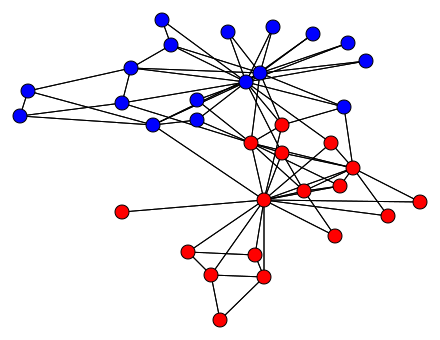

In [61]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first dimension to the ground-truth clusters.

In [62]:
spectral = Spectral(20, normalized=False)

In [63]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [64]:
# add first eigenvalue
eigenvalues = [1] + list(spectral.eigenvalues_)

(-1.1, 1.1)

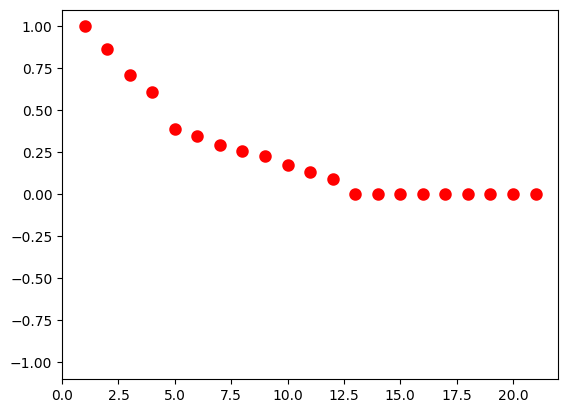

In [65]:
plt.scatter(np.arange(len(eigenvalues)) + 1, eigenvalues, color="r", lw=3)
plt.ylim(-1.1, 1.1)

The spectrum suggests the presence of 4 clusters (as there are 4 dominant eigenvalues). Interestingly, this is the number of clusters returned by Louvain.

In [66]:
eigenvectors = spectral.eigenvectors_

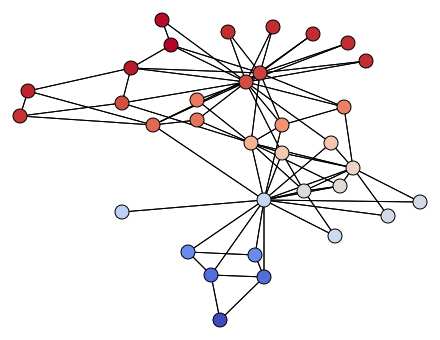

In [67]:
# display top eigenvector
image = svg_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

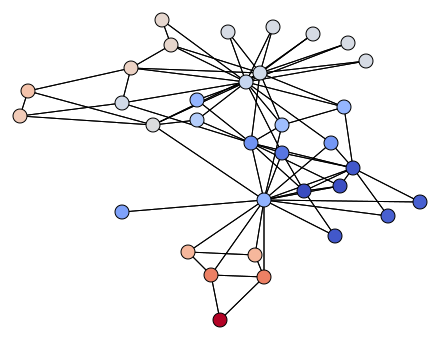

In [68]:
# next eigenvector
image = svg_graph(adjacency, position, scores=eigenvectors[:, 1])
SVG(image)

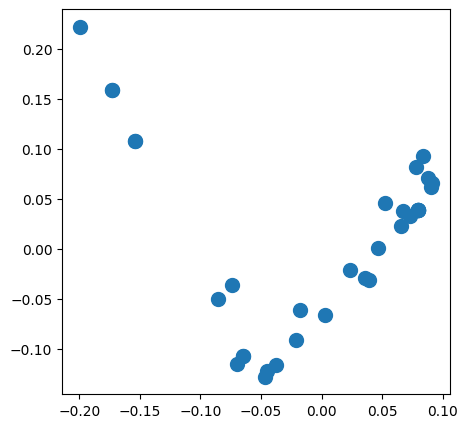

In [69]:
plt.figure(figsize=(5, 5))
plt.scatter(eigenvectors[:, 0], eigenvectors[:, 1], s=100)

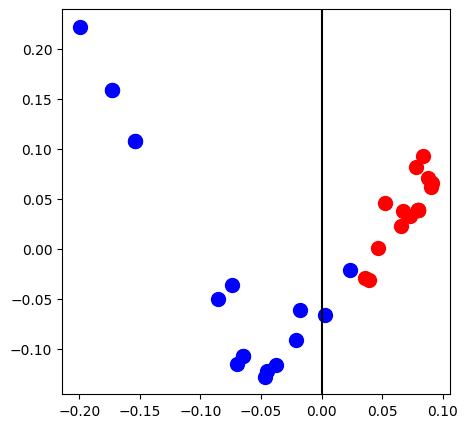

In [70]:
colors = ["r", "b"]
plt.figure(figsize=(5, 5))
for label in np.unique(labels_true):
    plt.scatter(
        eigenvectors[labels_true == label, 0],
        eigenvectors[labels_true == label, 1],
        s=100,
        c=colors[label],
    )
plt.axvline(c="k")

In [71]:
labels_pred = (eigenvectors[:, 0] > 0).astype(int)

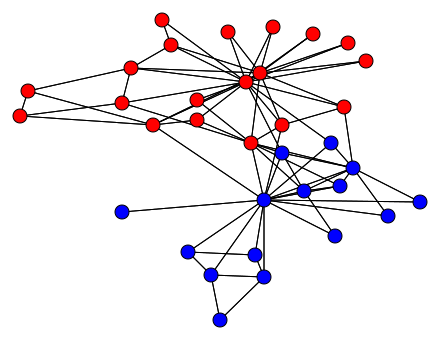

In [72]:
image = svg_graph(adjacency, position, labels=labels_pred)
SVG(image)

In [73]:
np.mean(labels_pred == labels_true)

0.058823529411764705

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [74]:
dataset = openflights

In [75]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

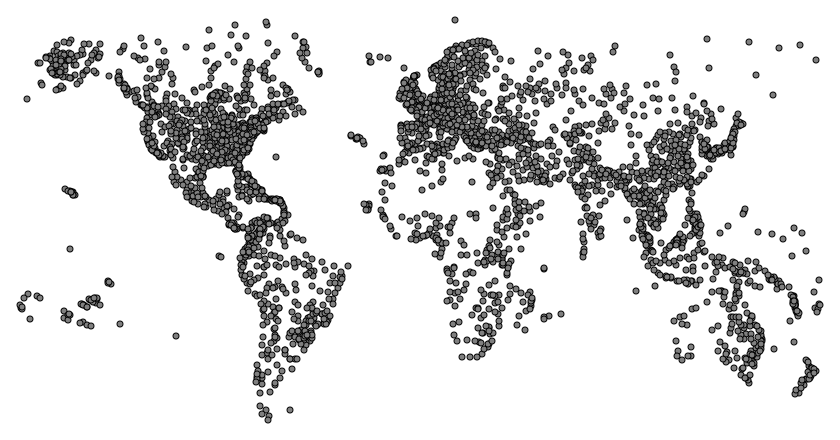

In [76]:
image = svg_graph(
    adjacency, position, width=800, height=400, node_size=3, display_edges=False
)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. You might compute the distance of the barycenter of each cluster to the origin.

In [77]:
k = 20
spectral = Spectral(k, normalized=True)

In [78]:
embedding = spectral.fit_transform(adjacency)

In [79]:
from sklearn.cluster import KMeans

In [80]:
kmeans = KMeans(8, n_init=10)

In [81]:
labels = kmeans.fit_predict(embedding)

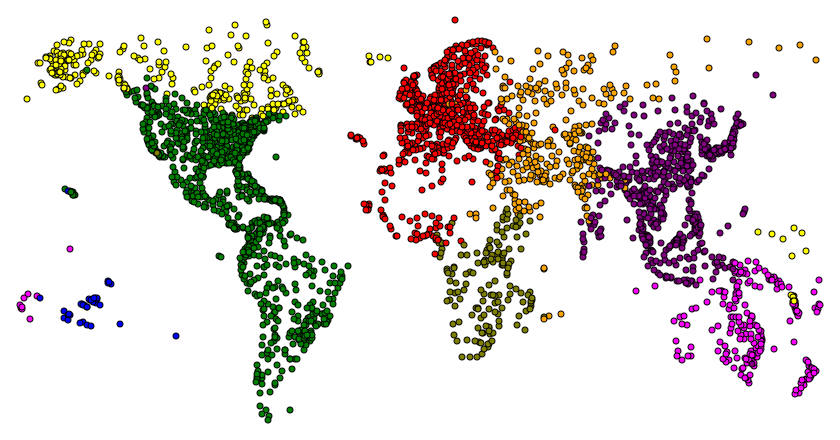

In [82]:
image = svg_graph(
    adjacency,
    position,
    width=800,
    height=400,
    node_size=3,
    labels=labels,
    display_edges=False,
)
SVG(image)

In [83]:
spectral = Spectral(k, normalized=False)

In [84]:
embedding = spectral.fit_transform(adjacency)

In [85]:
kmeans = KMeans(8, n_init=10)

In [86]:
labels = kmeans.fit_predict(embedding)

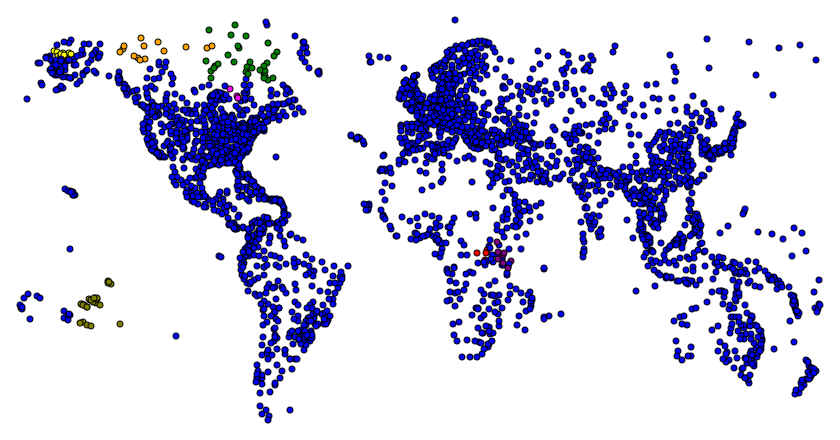

In [87]:
image = svg_graph(
    adjacency,
    position,
    width=800,
    height=400,
    node_size=3,
    labels=labels,
    display_edges=False,
)
SVG(image)

In [88]:
for label in np.unique(labels):
    mask = labels == label
    print(label, np.sum(mask), np.linalg.norm(np.mean(embedding[mask], axis=0)))

0 2999 0.00197699290376643
1 4 0.2327590606924316
2 31 0.08421633265300035
3 14 0.12142787072597035
4 9 0.1714290060163752
5 11 0.15454258188837497
6 4 0.2717131939729355
7 25 0.08295980546869426


In the absence of normalization, the small subgraphs that are weakly connected to the rest of the graph are isolated by the spectral embedding. Projecting the embedding on the unit sphere allows to see the main structure of the graph.

## 2. Directed and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we consider the embedding on the unit sphere (``normalized=True``).

## Wikipedia Vitals

In [89]:
dataset = wikivitals

In [90]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the graph of links.

* List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.
* Display the 3D-plot of each label in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the barycenter of the corresponding articles, with a size proportional to the number of articles.
* Display the dendrogram of the top-100 articles on **Arts** (in terms of Personalized PageRank) given by the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space (hierarchical clustering).

In [91]:
spectral = Spectral(20)

In [92]:
embedding = spectral.fit_transform(adjacency)

In [93]:
node = int(np.flatnonzero(names == "Vincent van Gogh"))

In [94]:
# cosine similarity
scores = embedding.dot(embedding[node])

In [95]:
print(names[np.argsort(-scores)[:10]])

['Vincent van Gogh' 'Georges Seurat' 'Paul Cézanne' 'Paul Gauguin'
 'Henri de Toulouse-Lautrec' 'Franz Marc' 'Post-Impressionism'
 'Edvard Munch' 'Henri Rousseau' "Musée National d'Art Moderne"]


In [96]:
labels_unique, counts = np.unique(labels, return_counts=True)

In [97]:
embedding_label = np.array(
    [np.mean(embedding[labels == label], axis=0) for label in labels_unique]
)

In [98]:
embedding_label.shape

(11, 20)

In [104]:
import pandas as pd
import plotly.express as px
import nbformat

In [105]:
dataframe = pd.DataFrame(embedding_label[:, :3], columns=list("xyz"))

In [106]:
dataframe["category"] = names_labels[labels_unique]
dataframe["count"] = counts

In [108]:
fig = px.scatter_3d(
    dataframe,
    x="x",
    y="y",
    z="z",
    text="category",
    color="category",
    size="count",
    size_max=100,
    opacity=0.5,
)
fig.update_layout(showlegend=False)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('category=%{text}<br>x=%{x}<br>' ... '=%{marker.size}<extra></extra>'),
              'legendgroup': 'Arts',
              'marker': {'color': '#636efa',
                         'opacity': 0.5,
                         'size': array([673], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.1991,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': 'Arts',
              'scene': 'scene',
              'showlegend': True,
              'text': array(['Arts'], dtype=object),
              'type': 'scatter3d',
              'x': array([0.18696351]),
              'y': array([0.17022348]),
              'z': array([-0.19031727])},
             {'hovertemplate': ('category=%{text}<br>x=%{x}<br>' ... '=%{marker.size}<extra></extra>'),
              'legendgroup': 'Biological and health sciences',
              'marker': {'color': '#EF553B',
                         'opacity': 0.5,
                         'size': array([1479], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.1991,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': 'Biological and health sciences',
              'scene': 'scene',
              'showlegend': True,
              'text': array(['Biological and health sciences'], dtype=object),
              'type': 'scatter3d',
              'x': array([-0.09424814]),
              'y': array([-0.31421941]),
              'z': array([-0.02581296])},
             {'hovertemplate': ('category=%{text}<br>x=%{x}<br>' ... '=%{marker.size}<extra></extra>'),
              'legendgroup': 'Everyday life',
              'marker': {'color': '#00cc96',
                         'opacity': 0.5,
                         'size': array([479], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.1991,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': 'Everyday life',
              'scene': 'scene',
              'showlegend': True,
              'text': array(['Everyday life'], dtype=object),
              'type': 'scatter3d',
              'x': array([0.0326133]),
              'y': array([-0.10898436]),
              'z': array([-0.00249645])},
             {'hovertemplate': ('category=%{text}<br>x=%{x}<br>' ... '=%{marker.size}<extra></extra>'),
              'legendgroup': 'Geography',
              'marker': {'color': '#ab63fa',
                         'opacity': 0.5,
                         'size': array([1201], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.1991,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': 'Geography',
              'scene': 'scene',
              'showlegend': True,
              'text': array(['Geography'], dtype=object),
              'type': 'scatter3d',
              'x': array([0.19171233]),
              'y': array([-0.18769547]),
              'z': array([0.10142066])},
             {'hovertemplate': ('category=%{text}<br>x=%{x}<br>' ... '=%{marker.size}<extra></extra>'),
              'legendgroup': 'History',
              'marker': {'color': '#FFA15A',
                         'opacity': 0.5,
                         'size': array([680], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.1991,
                         'symbol': 'circle'},
              'mode': 'markers+text',
              'name': 'History',
              'scene': 'scene',
              'showlegend': True,
              'text': array(['History'], dtype=object),
              'type': 'scatter3d',
              'x': array([0.20987682]),
              'y': array([-0.04097278]),
              'z': array([0.15381866])},
             {'hovertemplate

In [109]:
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


In [110]:
pagerank = PageRank()

In [111]:
scores = pagerank.fit_predict(adjacency, labels == 0)

In [112]:
scores *= labels == 0

In [113]:
top = np.argsort(-scores)[:100]

In [114]:
from scipy.cluster.hierarchy import linkage

In [115]:
dendrogram = linkage(embedding[top], method="ward")

In [116]:
from sknetwork.visualization import svg_dendrogram

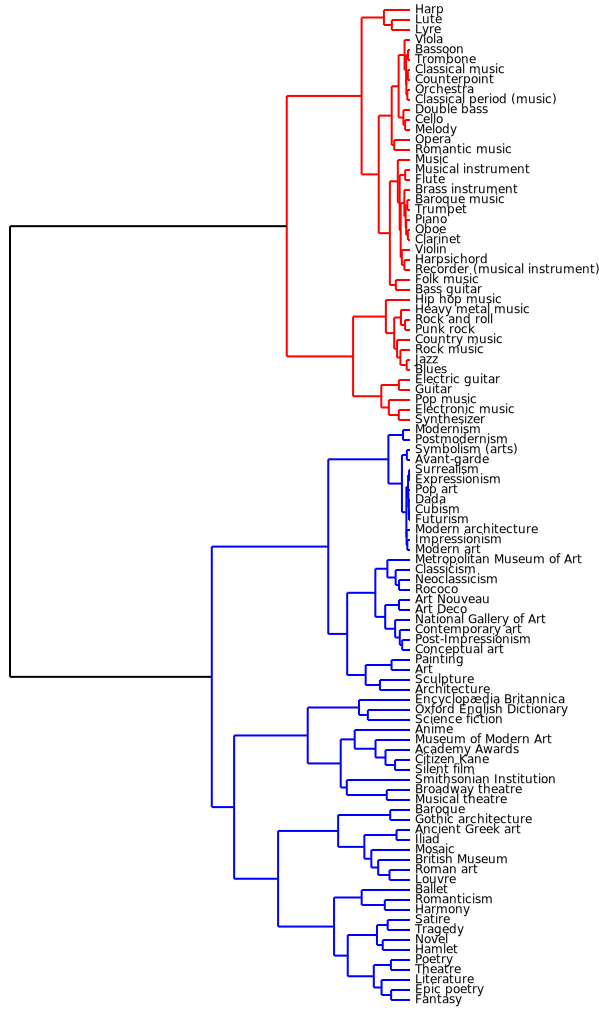

In [117]:
SVG(
    svg_dendrogram(
        dendrogram, names=names[top], rotate=True, rotate_names=True, height=1000
    )
)

## To do

* Repeat the same experiments of the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are the closest to the word **painting** in the embedding space.

In [118]:
embedding = spectral.fit_transform(biadjacency)

In [119]:
embedding_words = spectral.embedding_col_

In [120]:
# cosine similarity with articles
scores = embedding.dot(embedding_words[words == "painting"].ravel())

In [121]:
print(names[np.argsort(-scores)[:10]])

["Les Demoiselles d'Avignon" 'Hieronymus Bosch' 'Rembrandt' 'Modern art'
 'Peter Paul Rubens' 'Gian Lorenzo Bernini' 'Symbolism (arts)'
 'Constantin Brâncuși' 'Pieter Bruegel the Elder' 'Johannes Vermeer']


In [122]:
# cosine similarity with words
scores = embedding_words.dot(embedding_words[words == "painting"].ravel())

In [123]:
print(words[np.argsort(-scores)[:10]])

['painting' 'Rembrandt' 'Netherlandish' 'Bruegel' 'Painters' 'Demoiselles'
 'Rubens' 'portraiture' 'draughtsman' 'Vermeer']


## To do

* Check that the average cosine similarity between nodes in some set $S$ is given by the square distance of the barycenter of $S$ to the origin.

$$
\frac 1 {n^2}\sum_{i, j \in S}x_i.x_j = \left(\frac 1 n \sum_{i\in S}x_i\right).\left(\frac 1 n \sum_{j\in S}x_j\right) = ||\frac 1 n \sum_{i\in S}x_i||^2
$$

* Deduce the average cosine similarity between articles of the **Mammals** category.
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). 

In [124]:
biadjacency = dataset.biadjacency

In [125]:
spectral = Spectral(20)

In [126]:
embedding = spectral.fit_transform(biadjacency)

In [127]:
{
    label: name
    for label, name in enumerate(names_labels_hierarchy)
    if name.endswith("Mammals")
}

{329: 'Biological and health sciences|||Organisms|||Animals|||Mammals'}

In [128]:
mammal = 329

In [129]:
def get_average_cosine(mask):
    return np.linalg.norm(np.mean(embedding[mask], axis=0)) ** 2

In [130]:
get_average_cosine(labels_hierarchy == mammal)

0.9448758585495294

In [131]:
get_average_cosine(labels_hierarchy >= 0)

0.0068709755061681635

In [132]:
scores = np.array([get_average_cosine(labels == label) for label in np.unique(labels)])

In [133]:
for label in np.argsort(-scores):
    print(scores[label], names_labels[label])

0.838530017477476 Mathematics
0.547998191248854 Geography
0.48810415848675826 Philosophy and religion
0.37556957218276793 Technology
0.2899276419985333 Arts
0.27877096610228214 Biological and health sciences
0.27733534353157746 Everyday life
0.2501312365216818 Physical sciences
0.24424998271786313 History
0.24326601864260455 Society and social sciences
0.19248111208029925 People


In [134]:
labels_unique, counts = np.unique(labels_hierarchy, return_counts=True)

In [135]:
labels_top = labels_unique[counts >= 10]
counts_top = counts[counts >= 10]

In [136]:
scores = np.array(
    [get_average_cosine(labels_hierarchy == label) for label in labels_top]
)

In [137]:
for i in np.argsort(-scores)[:10]:
    label = labels_top[i]
    count = counts_top[i]
    print(scores[i], count, names_labels_hierarchy[label])

0.9921795558937498 14 People|||Sports figures|||Team sports|||Association football
0.9819232648805531 10 Physical sciences|||Astronomy|||Astronomical objects|||Notable stars
0.9807380600821385 14 Mathematics|||Algebra|||Abstract algebra
0.9803497837559539 10 Mathematics|||Geometry|||Topology
0.9749668732174112 14 People|||Musicians and composers|||Western art music|||Composers|||20th century modern
0.9745047857290123 18 Philosophy and religion|||Eastern religions|||Hinduism
0.9699673021877171 10 Arts|||Modern visual arts|||Filmmaking|||Films|||Drama film
0.9623690360606239 17 People|||Musicians and composers|||Popular music|||Rock
0.9609845247391385 10 Everyday life|||Sports and recreation|||Sports|||Athletics|||Track and field
0.9605375975360133 12 Biological and health sciences|||Health, medicine and disease|||Morbidity|||Mental disorder


In [138]:
for i in np.argsort(scores)[:10]:
    label = labels_top[i]
    count = counts_top[i]
    print(scores[i], count, names_labels_hierarchy[label])

0.30134327331007094 36 Arts|||Architecture|||Specific structures
0.41111122456332505 16 History|||History by subject matter
0.41114260726111973 20 History|||Modern history|||General
0.42548788652546987 22 People|||Writers|||Post-classical|||Asia
0.4256565818175467 10 People|||Military leaders and theorists|||Post-classical history
0.44069722357317476 17 People|||Scientists, inventors and mathematicians|||Life sciences|||General
0.44916052322498684 11 Society and social sciences|||Business and economics|||General|||Property
0.4492060945382545 12 People|||Scientists, inventors and mathematicians|||Ancient figures|||Post-classical
0.45410774263339876 10 Everyday life|||Sports and recreation|||Entertainment|||Entertainment and leisure
0.4822973206583444 13 History|||History by country|||Asia
